In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier #Added for a more robust model option
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc,f1_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/kaggle/input/project-4-diabetes-prediction/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<h1>EDA</h1>

In [5]:
df.shape

(768, 9)

In [6]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
df.duplicated().sum()

0

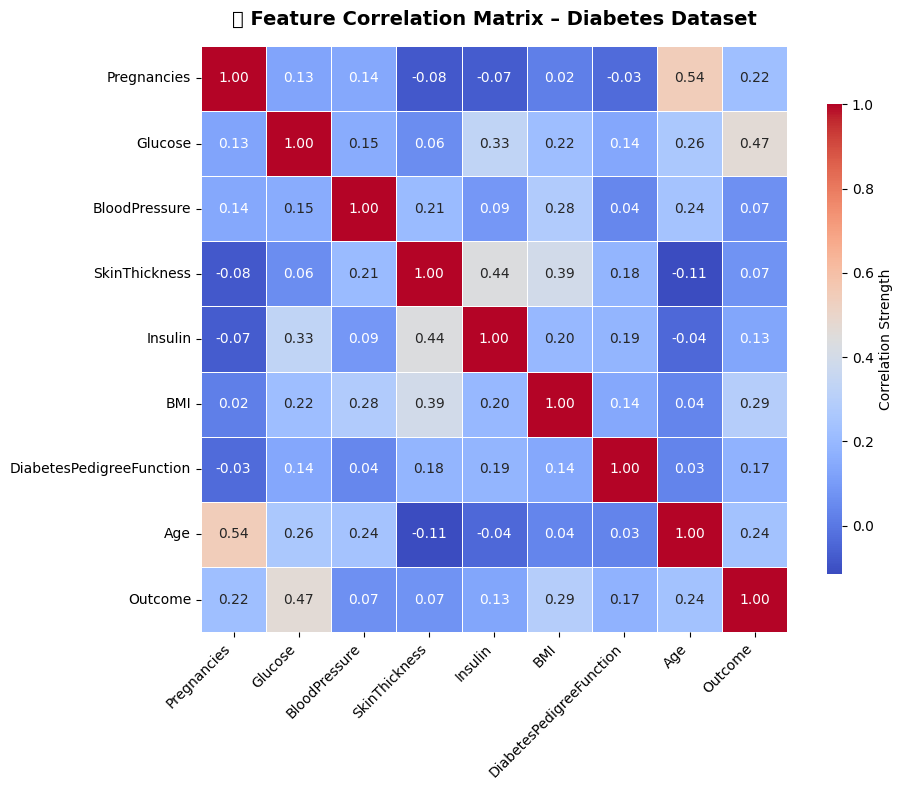

In [8]:
corr=df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    linewidths=0.5, 
    linecolor='white',
    square=True, 
    cbar_kws={'shrink': .8, 'aspect': 30, 'label': 'Correlation Strength'}
)

plt.title('🔗 Feature Correlation Matrix – Diabetes Dataset', fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

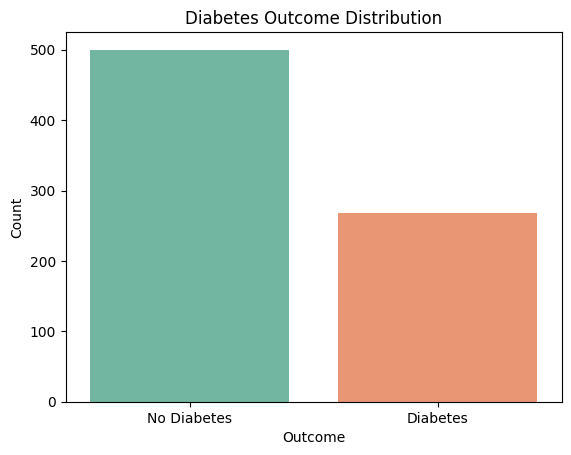

In [9]:
sns.countplot(x='Outcome', data=df, palette='Set2')
plt.title('Diabetes Outcome Distribution')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

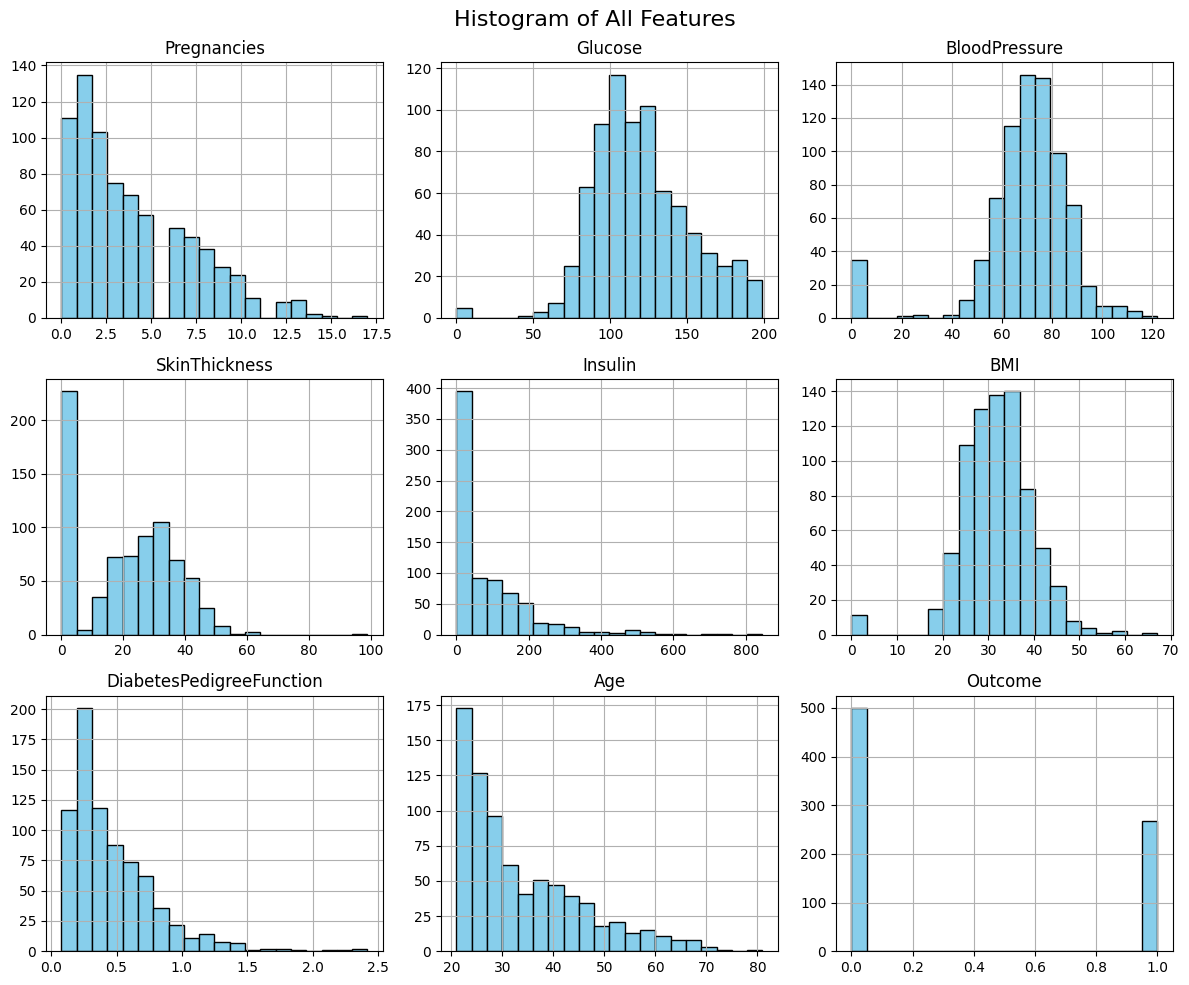

In [10]:
df.hist(figsize=(12, 10), bins=20, edgecolor='black', color='skyblue')
plt.suptitle('Histogram of All Features', fontsize=16)
plt.tight_layout()
plt.show()

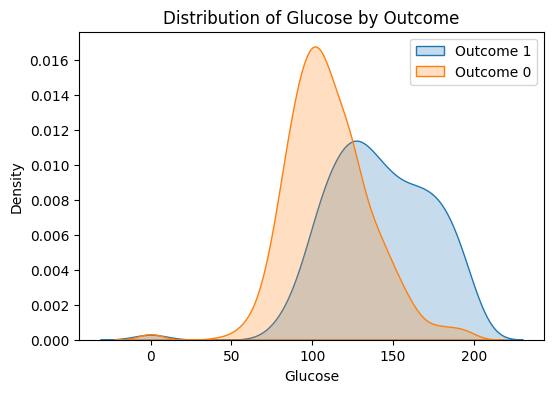

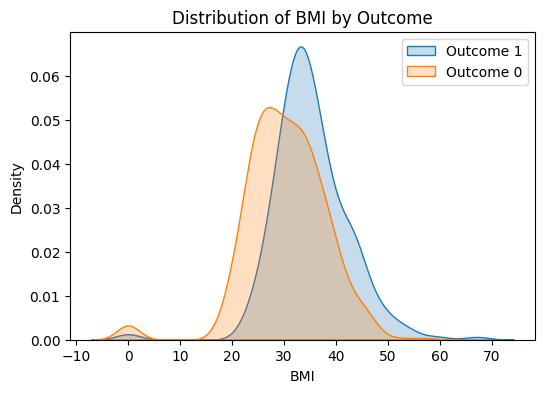

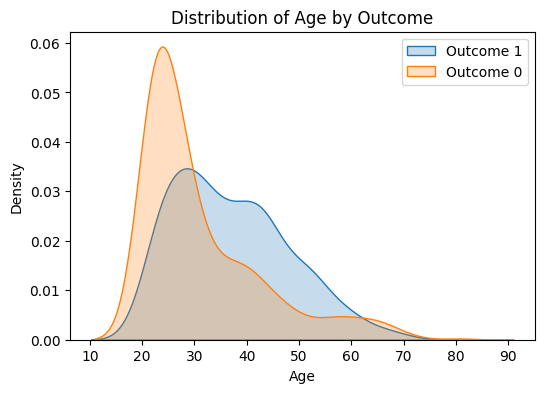

In [11]:
for col in ['Glucose', 'BMI', 'Age']:
    plt.figure(figsize=(6, 4))
    for label in df['Outcome'].unique():
        sns.kdeplot(df[df['Outcome'] == label][col], label=f'Outcome {label}', fill=True)
    plt.title(f'Distribution of {col} by Outcome')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

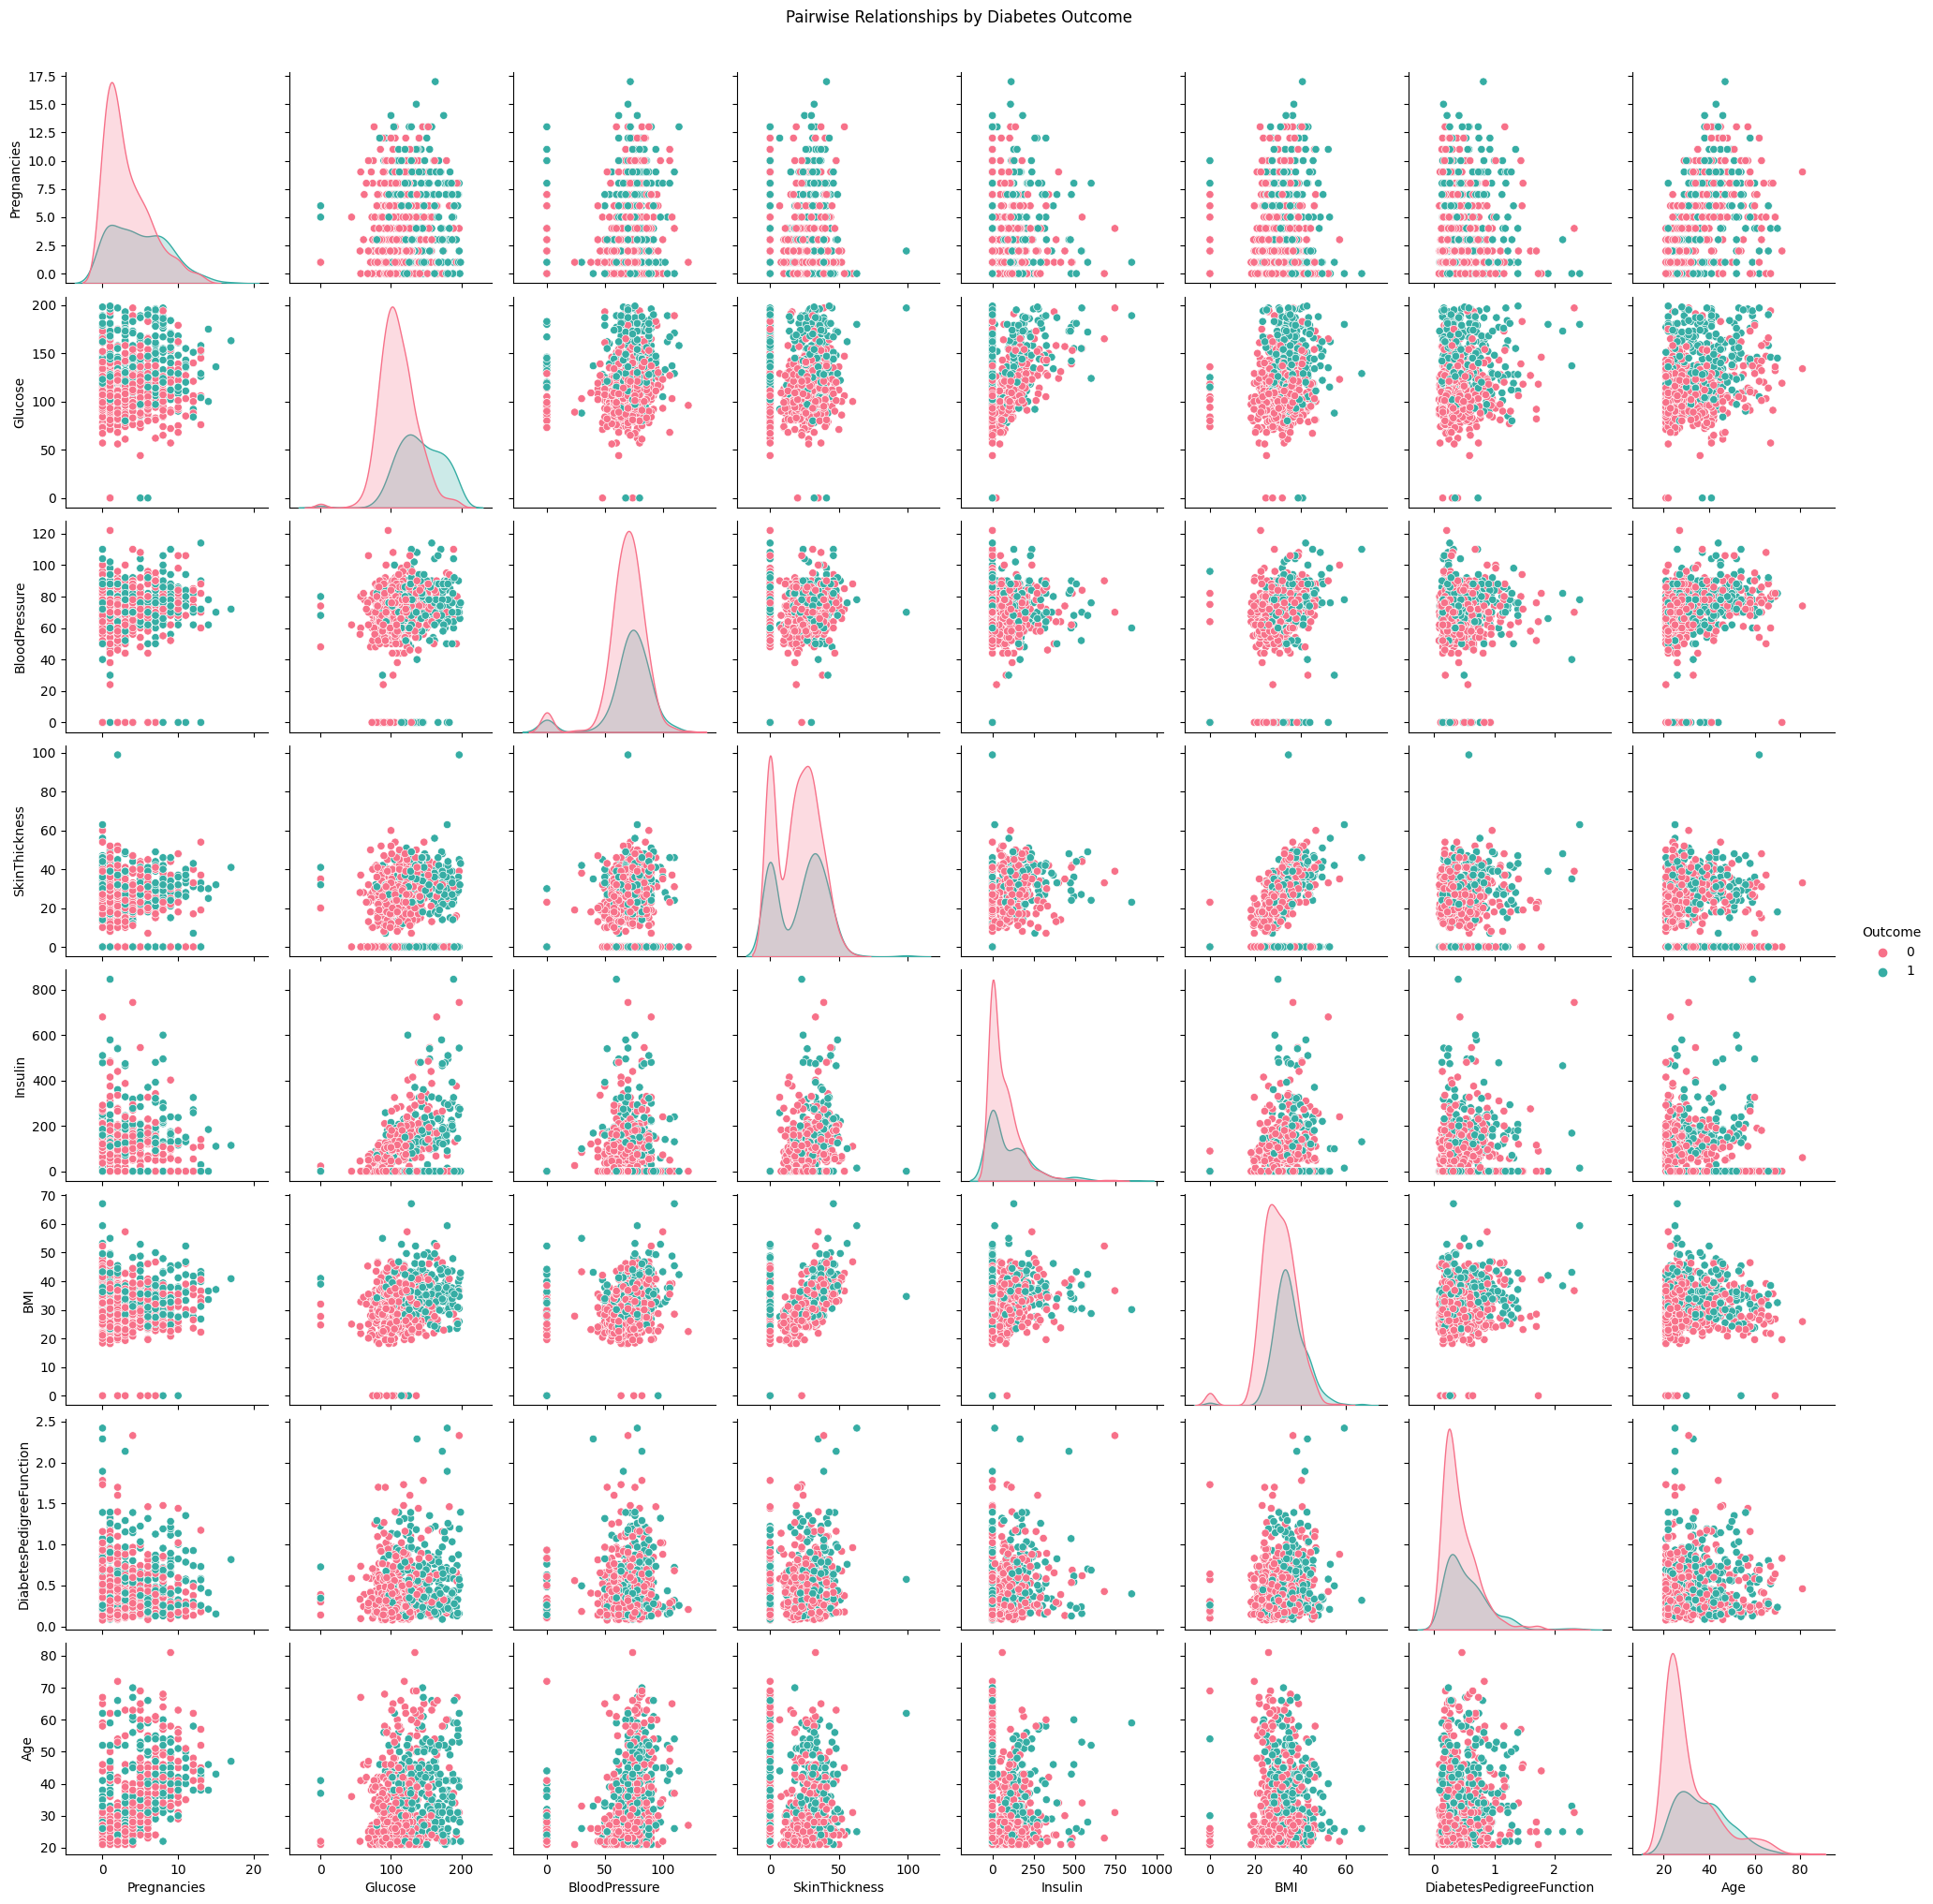

In [12]:
sns.pairplot(df, hue='Outcome', palette='husl', diag_kind='kde')
plt.suptitle('Pairwise Relationships by Diabetes Outcome', y=1.02)
plt.show()

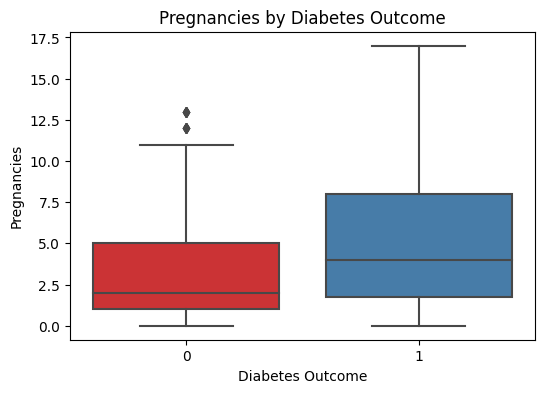

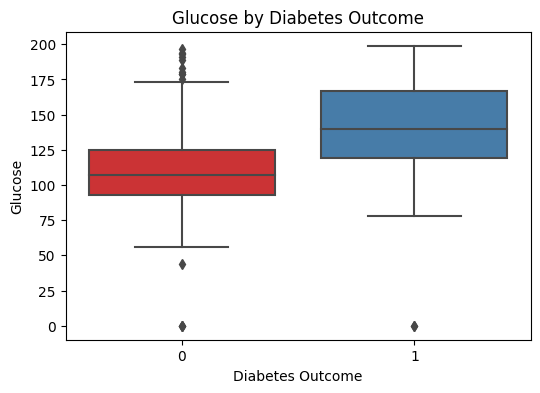

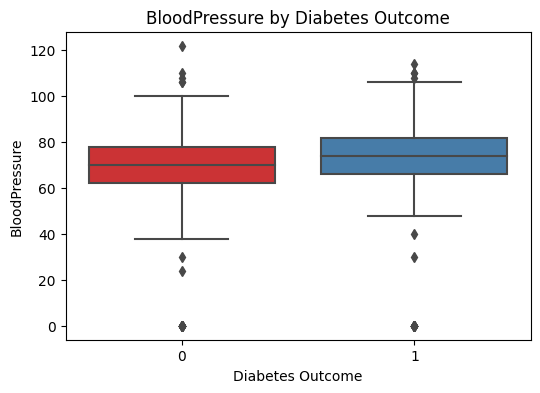

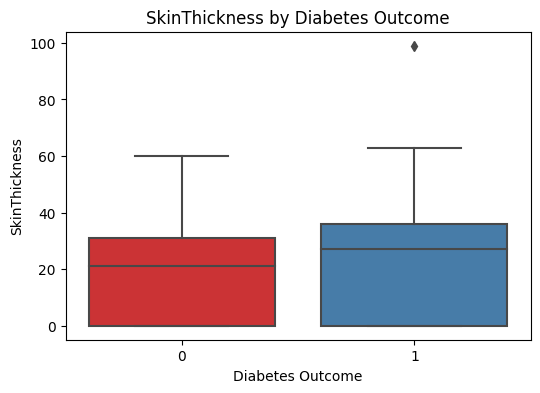

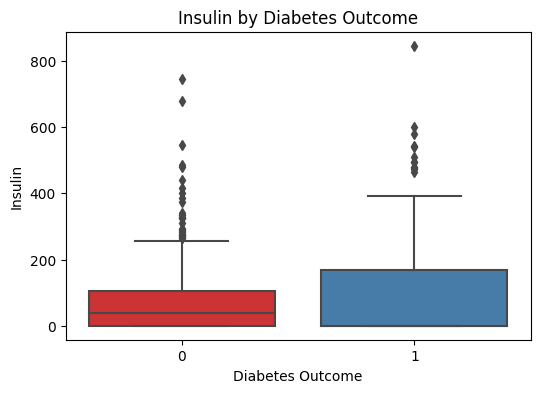

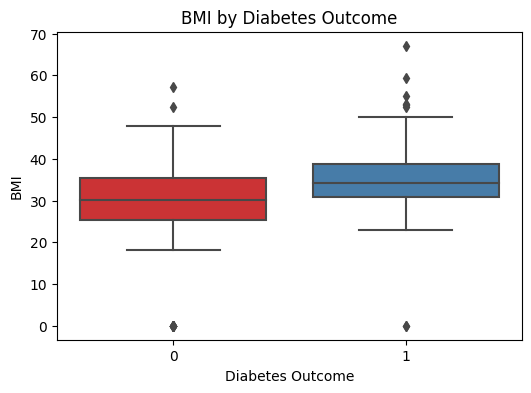

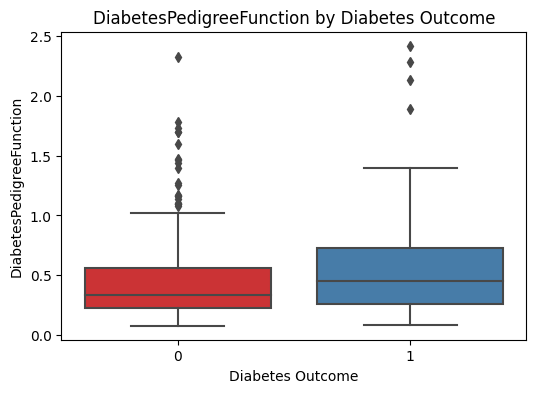

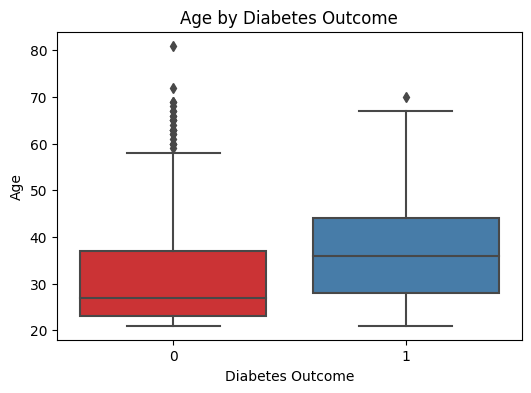

In [13]:
import seaborn as sns
features = df.columns[:-1]
for col in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Outcome', y=col, data=df, palette='Set1')
    plt.title(f'{col} by Diabetes Outcome')
    plt.xlabel('Diabetes Outcome')
    plt.ylabel(col)
    plt.show()

<h1>Oversampling</h1>

In [14]:
def balance_dataset(df, target_column):
    """
    Balance the dataset by oversampling the minority class

    """
    # Separate majority and minority classes
    majority = df[df[target_column] == 0]
    minority = df[df[target_column] == 1]

    print(f"Before Oversampling:\n{df[target_column].value_counts()}\n")

    # Upsample minority class
    minority_upsampled = resample(
        minority,
        replace=True,  # sample with replacement
        n_samples=len(majority),  # match majority count
        random_state=42
    )

    # Combine majority and upsampled minority
    df_oversampled = pd.concat([majority, minority_upsampled])

    print(f"After Oversampling:\n{df_oversampled[target_column].value_counts()}\n")

    # Plot class distribution before and after
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    df[target_column].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'orange'])
    axes[0].set_title('Before Oversampling')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')

    df_oversampled[target_column].value_counts().plot(kind='bar', ax=axes[1], color=['skyblue', 'orange'])
    axes[1].set_title('After Oversampling')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.savefig("Resampling")
    plt.show()

    return df_oversampled

Before Oversampling:
Outcome
0    500
1    268
Name: count, dtype: int64

After Oversampling:
Outcome
0    500
1    500
Name: count, dtype: int64



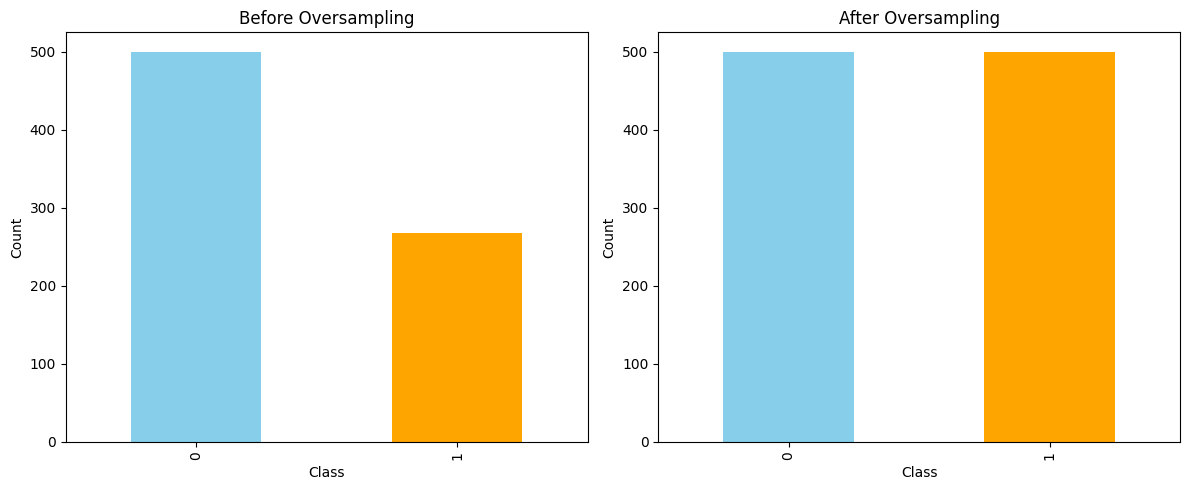

In [15]:
Unbalanced_data = df.copy()
balanced_data = balance_dataset(Unbalanced_data, 'Outcome')

In [29]:
copy_balanced = balanced_data.copy()

In [31]:
x = copy_balanced.drop('Outcome', axis=1)  # X contains all columns except the target
y = copy_balanced['Outcome']

# Here, test_size=0.2 means 20% test data, 80% train data. Set random_state for reproducibility.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [32]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 8)
(200, 8)
(800,)
(200,)


<H1>Logistic Regression</H1>

In [36]:
lr= LogisticRegression(max_iter =1000, random_state=42)
lr.fit(x_train, y_train)
lr_pred=lr.predict(x_test)
lr_acc=accuracy_score(y_test, lr_pred)
lr_f1=f1_score(y_test, lr_pred)

In [37]:
print("Accuracy score: ", lr_acc)
print("F1 Score: ", lr_f1)

Accuracy score:  0.775
F1 Score:  0.782608695652174


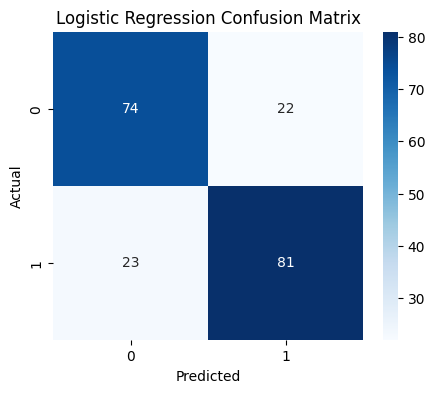

In [39]:
lr_cm = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(5,4))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("Logistic Regression Matrix")
plt.show()

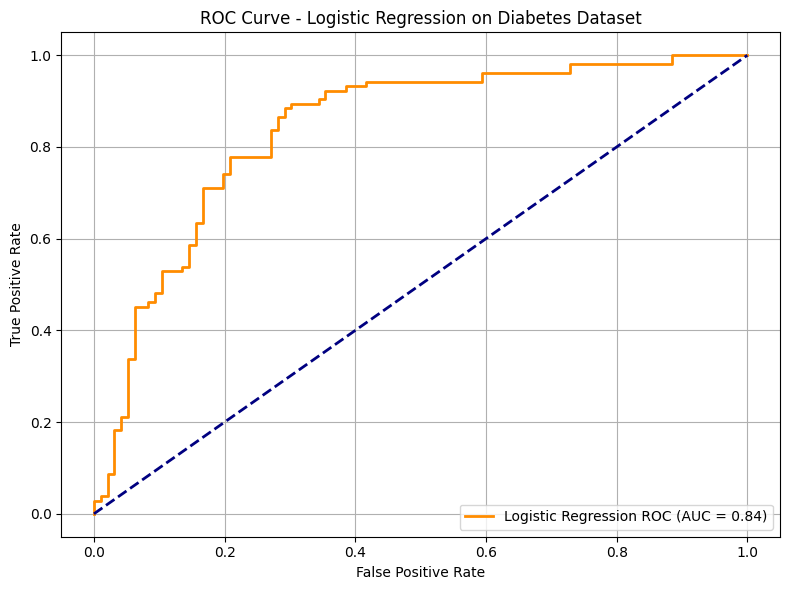

In [43]:
lr_prob = lr.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, lr_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Logistic Regression ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression on Diabetes Dataset')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

<h1>Random Forest</h1>

In [44]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
rf_pred= rf.predict(x_test)
rf_acc=accuracy_score(y_test, rf_pred)
rf_f1=f1_score(y_test, rf_pred)

In [45]:
print("Accuracy Score: ", rf_acc)
print("F1 Score: ", rf_f1)

Accuracy Score:  0.905
F1 Score:  0.9090909090909091


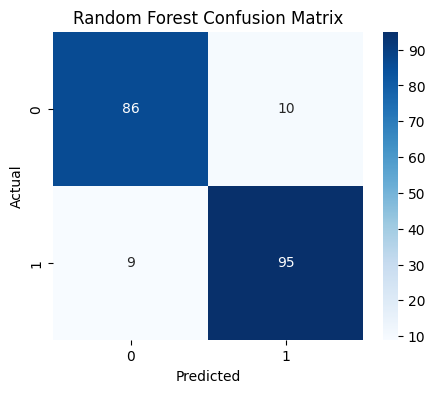

In [46]:
rf_cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(5,4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("Random Forest Matrix")
plt.show()

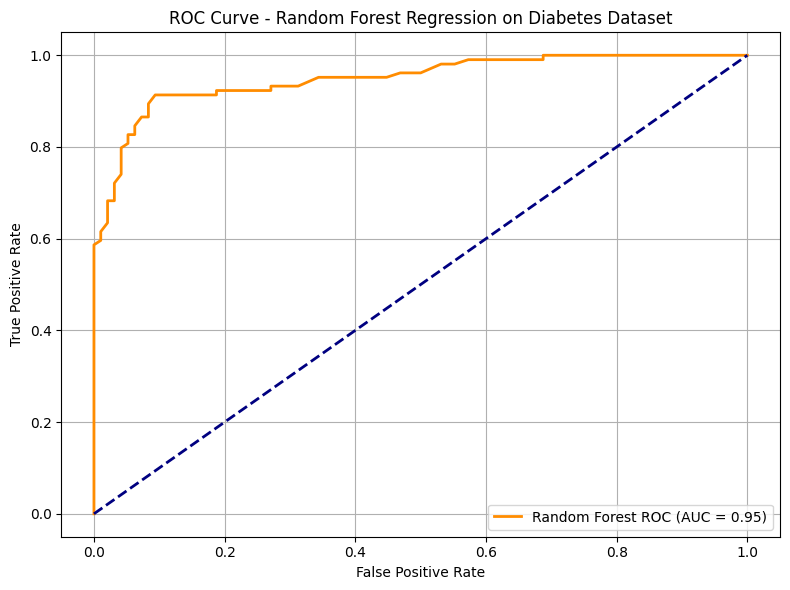

In [47]:
rf_prob = rf.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, rf_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Regression on Diabetes Dataset')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

<h1>CatBoost</h1>

In [48]:
cb = CatBoostClassifier(random_state=42, verbose=0)
cb.fit(x_train, y_train)
cb_pred=cb.predict(x_test)
cb_acc=accuracy_score(y_test, cb_pred)
cb_f1 = f1_score(y_test, cb_pred)

In [49]:
print("Accuracy Score: ", cb_acc)
print("F1 Score: ", cb_f1)

Accuracy Score:  0.865
F1 Score:  0.8744186046511627


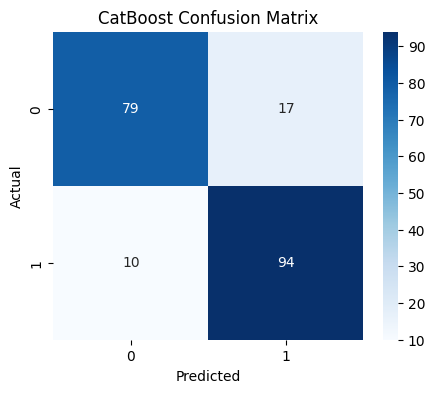

In [50]:
rf_cm = confusion_matrix(y_test, cb_pred)
plt.figure(figsize=(5,4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('CatBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("CatBoost Matrix")
plt.show()

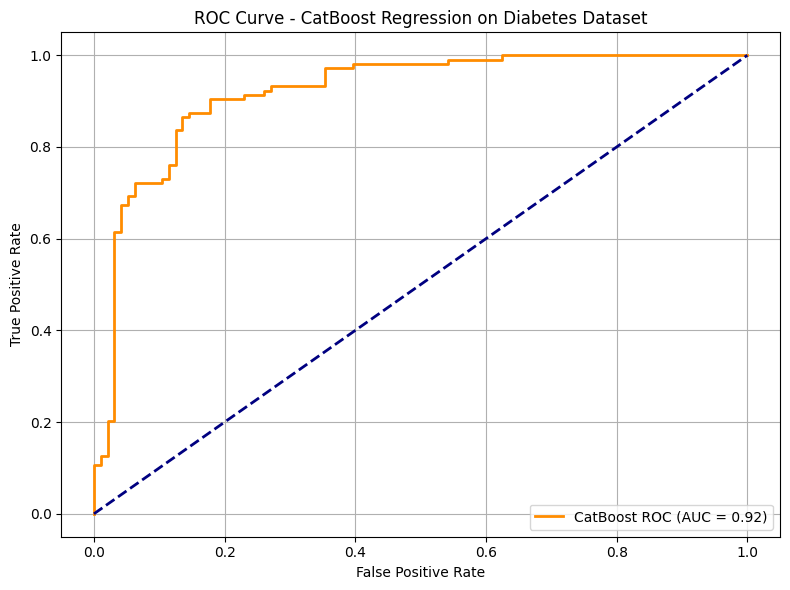

In [51]:
cb_prob = cb.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, cb_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'CatBoost ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost Regression on Diabetes Dataset')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

<h1>LightGBM Classifier</h1>

In [64]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(x_train, y_train)
lgbm_pred=lgbm.predict(x_test)
lgbm_acc=accuracy_score(y_test, lgbm_pred)
lgbm_f1=f1_score(y_test, lgbm_pred)

[LightGBM] [Info] Number of positive: 396, number of negative: 404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495000 -> initscore=-0.020001
[LightGBM] [Info] Start training from score -0.020001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [65]:
print("Accuracy Score: ", lgbm_acc)
print("F1 Score: ", lgbm_f1)

Accuracy Score:  0.865
F1 Score:  0.872037914691943


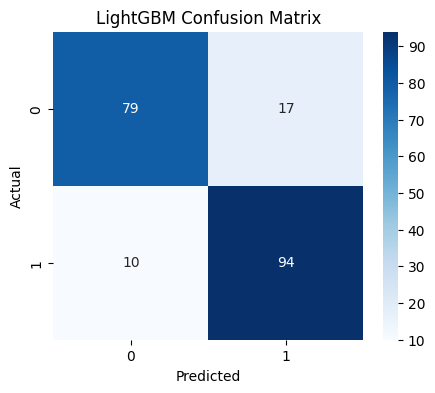

In [66]:
lgbm_cm = confusion_matrix(y_test, lgbm_pred)
plt.figure(figsize=(5,4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('LightGBM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("LightGBM Matrix")
plt.show()

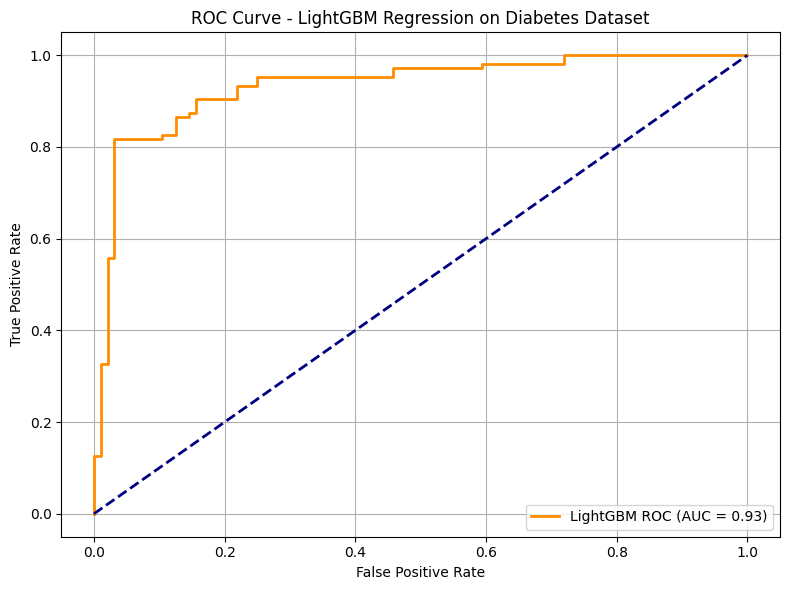

In [68]:
lgbm_prob = lgbm.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, lgbm_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'LightGBM ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM Regression on Diabetes Dataset')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

<h1>Comparative Study</h1>

In [75]:
model_names = ['Logistic Regression', 'LightGBM', 'CatBoost', 'Random Forest']
accuracy_scores = [lr_acc, lgbm_acc, cb_acc, rf_acc]
f1_scores =      [lr_f1, lgbm_f1, cb_f1, rf_f1]

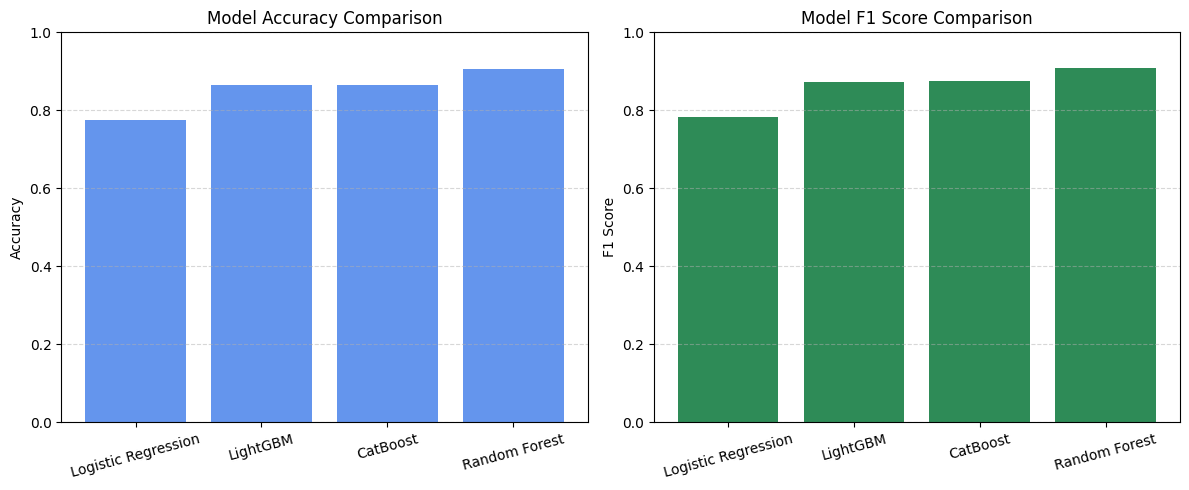

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.bar(model_names, accuracy_scores, color='cornflowerblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# F1 Score subplot
plt.subplot(1, 2, 2)
plt.bar(model_names, f1_scores, color='seagreen')
plt.title('Model F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
